In [1]:
import numpy as np
n = 30 # number of variables
M = 50 # number of censored observations
K = 200 # total number of observations

np.random.seed(n*M*K)
X = np.random.randn(K*n).reshape(K, n)
c_true = np.random.rand(n)

# generating the y variable
y = X.dot(c_true) + .3*np.sqrt(n)*np.random.randn(K)

# ordering them based on y
order = np.argsort(y)
y_ordered = y[order]
X_ordered = X[order,:]

#finding boundary
D = (y_ordered[M-1] + y_ordered[M])/2.

# applying censoring
y_censored = np.concatenate((y_ordered[:M], np.ones(K-M)*D))

import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

def plot_fit(fit, fit_label):
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(y_censored, 'bo', label = 'censored data')
    plt.plot(y_ordered, 'co', label = 'uncensored data')
    plt.plot(fit, 'ro', label=fit_label)
    plt.ylabel('y')
    plt.legend(loc=0)
    plt.xlabel('observations');

In [2]:
# plt.plot(y_ordered)
# print(D)

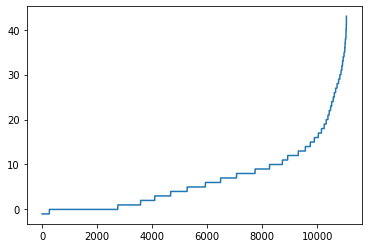

In [36]:
import pandas as pd
import time
from datetime import datetime
from time import mktime
data = pd.read_csv('ignition_data_9_21.csv')
cols_keep = ['num_players_5','num_players_25','num_players_50','num_players_200','num_players_500']
data['pub_date_struct'] = data.apply(lambda x: time.strptime(x['pub_date'],"%Y-%m-%d %H:%M:%S.%f%z"),axis=1)
data.index = data.apply(lambda x: datetime.fromtimestamp(mktime(x['pub_date_struct'])),axis=1)
a = (2020,9,19,4,25)
b = (2020,9,19,7,20)
data = data[(data.index < datetime(*a)) | (data.index > datetime(*b))]
data['hour'] = data.apply(lambda x: str(time.strptime(x['pub_date'],"%Y-%m-%d %H:%M:%S.%f%z")[3]), axis=1)
data['day_of_week'] = data.index.map(lambda x: x.weekday())
hour_dummies = pd.get_dummies(data['hour'], drop_first=True)
hour_dummies.columns = ['h'+ elem for elem in hour_dummies.columns]
day_of_week_dummies = pd.get_dummies(data['day_of_week'], drop_first=True)
day_of_week_dummies.columns = ['dow'+str(elem) for elem in day_of_week_dummies.columns]
data = data[cols_keep]
data = pd.concat((data,hour_dummies,day_of_week_dummies), axis=1)
y = data['num_players_500']
data = data.drop(labels='num_players_500',axis=1)
# print(data.columns)
# print(data.shape)
# print(data.values)
X = np.array(data.values)
y = np.array(y.values)
# print(y)
order = np.argsort(y)
y_ordered = y[order]
X_ordered = X[order,:]
M = np.argmax(y_ordered >= 50)
D = 50
n = data.shape[1]
plt.plot(y_ordered)

WARN: A->p (column pointers) not strictly increasing, column 39 empty
WARN: A->p (column pointers) not strictly increasing, column 40 empty
WARN: A->p (column pointers) not strictly increasing, column 41 empty
WARN: A->p (column pointers) not strictly increasing, column 42 empty
WARN: A->p (column pointers) not strictly increasing, column 43 empty
WARN: A->p (column pointers) not strictly increasing, column 44 empty
WARN: A->p (column pointers) not strictly increasing, column 45 empty
WARN: A->p (column pointers) not strictly increasing, column 46 empty
WARN: A->p (column pointers) not strictly increasing, column 59 empty
WARN: A->p (column pointers) not strictly increasing, column 60 empty
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 75182
eps = 1.00e-04, a

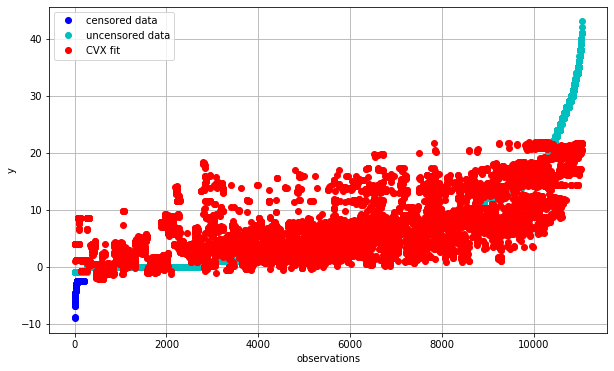

In [38]:
import cvxpy as cp
# X_uncensored = X_ordered[:M, :]
X_uncensored = X_ordered
c = cp.Variable(shape=n)
objective = cp.Minimize(cp.sum_squares(X_uncensored@c - y_ordered))
# objective = cp.Minimize(cp.sum_squares(X_uncensored@c - y_ordered[:M]))
# constraints = [ X_ordered[M:,:]@c >= D]
prob = cp.Problem(objective, constraints)
# result = prob.solve(verbose=True,max_iter=20000)
# result = prob.solve(verbose=True,solver = cp.ECOS)
# result = prob.solve(verbose=True,solver = cp.MOSEK) # not installed
# result = prob.solve(verbose=True,solver = cp.CBC) # not installed
# result = prob.solve(verbose=True,solver = cp.CVXOPT) # not installed
# result = prob.solve(verbose=True,solver = cp.NAG) # not installed
result = prob.solve(verbose=True,solver = cp.SCS,max_iters=20000)

c_cvx = np.array(c.value).flatten()
fit_cvx = X_ordered.dot(c_cvx)
plot_fit(fit_cvx, 'CVX fit')
print(c_cvx.shape)

In [39]:
np.savetxt('cvxpy_constraint_num_plrs_500.txt', c_cvx, fmt='%f')
# b = np.loadtxt('cvxpy_constraint_num_plrs_25.txt', dtype=float)
# print(c_cvx-b)

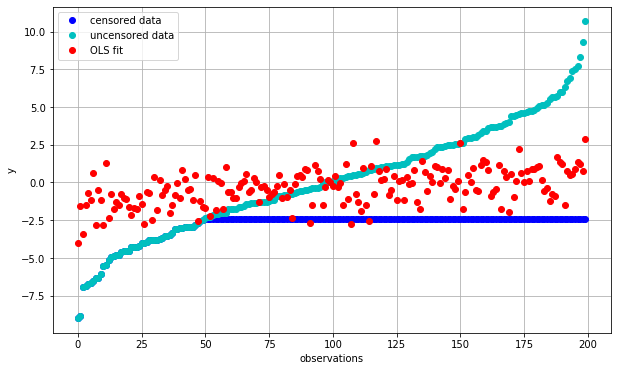

In [8]:
c_ols = np.linalg.lstsq(X_ordered, y_censored, rcond=None)[0]
fit_ols = X_ordered.dot(c_ols)
plot_fit(fit_ols, 'OLS fit')

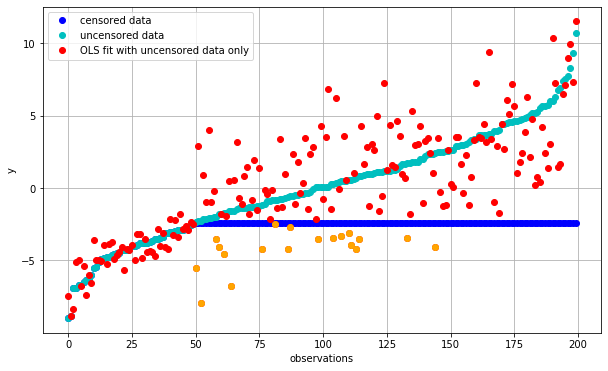

In [3]:
c_ols_uncensored = np.linalg.lstsq(X_ordered[:M], y_censored[:M], rcond=None)[0]
fit_ols_uncensored = X_ordered.dot(c_ols_uncensored)
plot_fit(fit_ols_uncensored, 'OLS fit with uncensored data only')

bad_predictions = (fit_ols_uncensored<=D) & (np.arange(K)>=M)
plt.plot(np.arange(K)[bad_predictions], fit_ols_uncensored[bad_predictions], color='orange', marker='o', lw=0);


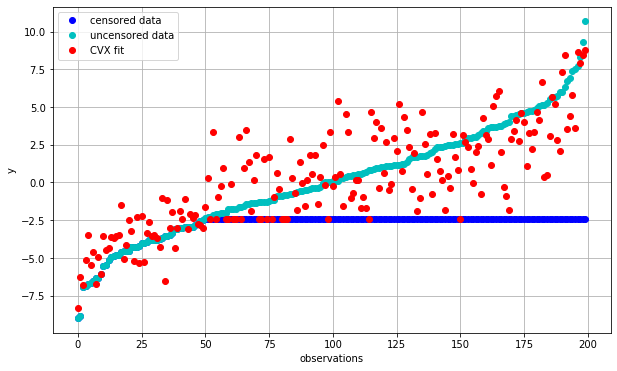

In [10]:
import cvxpy as cp
X_uncensored = X_ordered[:M, :]
c = cp.Variable(shape=n)
objective = cp.Minimize(cp.sum_squares(X_uncensored@c - y_ordered[:M]))
constraints = [ X_ordered[M:,:]@c >= D]
prob = cp.Problem(objective, constraints)
result = prob.solve()

c_cvx = np.array(c.value).flatten()
fit_cvx = X_ordered.dot(c_cvx)
plot_fit(fit_cvx, 'CVX fit')